# Gets Sports Schedule
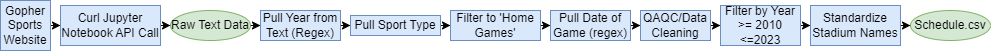

Credits: chat.openai.com and draw.io

## Import Statments

In [11]:
import os
os.environ['LC_ALL'] = 'en_US.UTF-8'
os.environ['LANG'] = 'en_US.UTF-8'
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
#location to current directory
file_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath) + '\\final_files'
os.chdir(file_path)
arcpy.env.workspace = file_path
print(arcpy.env.workspace)

C:\Users\Track\OneDrive\Documents\ArcGIS\Projects\ArcIIFinalTransitProject\final_files


In [12]:
import csv
import time
from datetime import datetime
import subprocess
import re
import pandas as pd

## Curl Code to Get All Games

In [13]:
#function to adjust year based on month if it is a split year season
def adjust_year(year_str, month_str):
    #checks if the year is split e.g., 2008-09
    if '-' in year_str:
        year_range = year_str.split('-')
        year1, year2 = map(int, year_range)
        if year1 == 1899:  #ff year1 is 1899, year2 will be 1900
            year_str = '1900'
        elif year1 == 1999:  #ff year1 is 1999, year2 will be 2000
            year_str = '2000'
        elif str(year1).startswith('18'):  #ff year1 starts with '18', add 1800 to year2
            year_str = str(year2 + 1800)
        elif str(year1).startswith('19'):  #ff year1 starts with '19', add 1900 to year2
            year_str = str(year2 + 1900)
        elif str(year1).startswith('20'):  #ff year1 starts with '20', add 2000 to year2
            year_str = str(year2 + 2000)
        if int(month_str) > 5:  #if month is June or later, use year1
            year_str = str(year1)
    return year_str


#initialize a list to store all sport rows
all_data_rows = []
#range of all games.
sport_list = list(range(1, 800))
#loop to go through the sport text schedules and pull out rows.
for gamecode in sport_list:
    #URL for display of sport schedule in text, gamecode changes the schedule.
    url = f"https://gophersports.com/services/schedule_txt.ashx?schedule={gamecode}"
    print(gamecode)
    #retry until text content is fetched successfully, provides lots of 404 errors
    while True:
        #send a request to the URL using curl
        curl_process = subprocess.Popen(['curl', '-s', url], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        response, error = curl_process.communicate()
        #check if the request was successful, if so then continue with code.
        if curl_process.returncode == 0:
            #split the text content by new line to get each line
            lines = response.decode('utf-8').split("\n")
            try:
            #gets the second row of the text. This contains the sport and year.
                second_row = lines[1].strip()
            except IndexError:
            #prevent code from breaking if the text page has no schedule.
                print(f"Index Error for {gamecode}. No Schedule")
                break  #move to the next gamecode if index error occurs
            #looks for a year value within year and season
            year_str_match = re.match(r'(\d{4}-\d{2}|\d{4})', second_row)
            #ensures the year was pulled successfully
            year_str = year_str_match.group(1) if year_str_match else None
            #quality Control, remove Schedule from the end of the season column, just names sports and year. 
            season = second_row.replace("Schedule", "").strip()
            #quality Control, check if the season contains the busier sports.
            if any(sport in season for sport in ["Football", "Volleyball", "Men's Basketball", "Men's Hockey", "Men's Ice Hockey"]):
                #skip the first 10 rows, they are not in the right format
                for line in lines[10:]:
                    #strip whitespace and split the line based on multiple spaces
                    data = re.split(r'\s{2,}', line.strip())
                    #quality control, check if the row has more than 2 elements and the third element is a Home game.
                    if len(data) > 2 and data[2] not in ["Away", "Neutral"]:
                        #append the split data to data_rows with the year and season values added
                        if data[0] != "Date" or data[1] != "Time":  #add this condition to select rows with "Date" and "Time"
                            #extracting only the date part without the day of the week. Goes from Oct 10 (Fri) to Oct 10
                            date_without_day = re.sub(r'\s*\([^)]*\)', '', data[0])
                            #extract month from the date. Add 2000 so it will accept Leap Year dates. Does not impact year as year is pulled from line 2. 
                            month_str = datetime.strptime(date_without_day + " 2000", "%b %d %Y").strftime("%m")
                            #adjust the year based on month
                            year_str_for_row = adjust_year(year_str, month_str)
                            #combine date with year and format it as "mm/dd/yyyy"
                            combined_date = datetime.strptime(f"{date_without_day} {year_str_for_row}", "%b %d %Y").strftime("%m/%d/%Y")
                            #puts date in first column
                            data[0] = combined_date
                            #adds column for year and season
                            all_data_rows.append([year_str_for_row, season] + data)
            break  #exit the loop if data is fetched successfully
        else:
            #print an error message if the request was not successful
            print(f"Error: {error.decode('utf-8')} at {url}")
        #wait for 0 second before retrying
        time.sleep(0)
    
#write all games to CSV
output_file = f"schedule_all.csv"
with open(output_file, "w", newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    #write header row with the columns we want
    writer.writerow(["Year", "Season", "Date", "Time", "At", "Opponent", "Location", "Score"])
    #write data rows for all games extracted
    writer.writerows(all_data_rows)
print(f"Data written to '{output_file}'")

1
2
3
Index Error for 3. No Schedule
4
Index Error for 4. No Schedule
5
Index Error for 5. No Schedule
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254

## Check the CSV

In [14]:
#f to convert time format
def convert_time(time_str):
    #check if the time string contains 'A.M.' or 'P.M.' and replace them accordingly
    if 'A.M.' in time_str:
        return time_str.replace('A.M.', 'AM')
    elif 'P.M.' in time_str:
        return time_str.replace('P.M.', 'PM')
    else:
        return time_str 

#assuming your CSV file is named "your_file.csv", adjust the file name accordingly
file_path = "schedule_all.csv"
#read the CSV file into a DataFrame
df = pd.read_csv(file_path)
df['Time'] = df['Time'].apply(convert_time)
#gets rid of row if stadium is TBD
qaqc_df = df[(~df['Location'].str.contains('TBD'))].copy()
#filter out rows where 'Time' contains 'TBA' or 'TBD'
qaqc_df = qaqc_df[~df['Time'].str.contains(r'^[^0-9]*$', regex=True)].copy() 
#removes rows that have other state names in the location.
qaqc_df = qaqc_df[~qaqc_df['Location'].str.contains('Calif.|Ind.|Colo.|N.Y.')]
#QC: Range Check. Logical Check
qaqc_df = qaqc_df[(qaqc_df['Year'] <= 2023) & (qaqc_df['Year'] >= 2013)]
#QC: Thematic Accuracy - Consistent Stadium Names
qaqc_df.loc[qaqc_df['Location'] == 'TCF Bank Stadium', 'Location'] = 'Huntington Bank Stadium'
qaqc_df.loc[qaqc_df['Location'] == 'Mariucci Arena', 'Location'] = '3M Arena at Mariucci'
qaqc_df.loc[qaqc_df['Location'] == 'Sports Pavilion', 'Location'] = 'Maturi Pavilion'
#replaces "TBD (Stadium)" with just the stadium name.
qaqc_df['Location'] = qaqc_df['Location'].str.replace(r'\bTBD \((.+?)\)', r'\1', regex=True)
qaqc_df['Location'] = qaqc_df['Location'].str.replace(r'.*\((.*)\).*', r'\1', regex=True)
#take years out of the season column
qaqc_df['Season'] = qaqc_df['Season'].str.replace(r'\d+|-', '', regex=True)
#take Men's or Women's Label Off
qaqc_df['Season'] = qaqc_df['Season'].str.replace(r"Men's|Women's|Ice", '', regex=True)
#get rid of last column, was only needed for formatting.
qaqc_df.drop('Score', axis=1, inplace=True)
newpath = "qaqc_schedule.csv"
#write the filtered DataFrame to a new CSV file
qaqc_df.to_csv(newpath, index=False)
print(f"Filtered data written to '{newpath}'")

[14]:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Filtered data written to 'qaqc_schedule.csv'
